In [305]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

import yaml

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [306]:
ROOT_DIR = "../../data/bias_triangles"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")

config_path = "./config.yaml"

model_name = 'psb'

with open(config_path, 'r') as config_yaml:
            model_yaml = yaml.load(config_yaml, Loader=yaml.FullLoader)
            model_config = model_yaml[model_name]
            model_info = model_config['info']
            model_hyperparams = model_config['hyperparameters']

            model_device = model_yaml['device']


In [307]:
def get_bias_triangle_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_bias_triangle_11Apr2024_12h19m_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        record["file_name"] = os.path.join(img_dir, v["filename"])
        record["image_id"] = idx

        annos = v["regions"]

        objs = []

        if type(annos) == list: # custom JSONs are in list format need to make them the same
             annos = dict(enumerate(annos))

        for _, anno in annos.items():

            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            # if len(px) <= 10 or len(py) <= 10:
            #         # print("Ignoring polygon from ", v["filename"], "because a polygon was too small for detectron2.")
            #         continue
            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]


            category_dict = {"unblocked": 0, "blocked": 1}
            category_id = category_dict[regions["label"]]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

../../data/bias_triangles/processed/train/train_12_blocked.jpg
../../data/bias_triangles/processed/train/train_581_0_sim_unblocked.jpg
../../data/bias_triangles/processed/train/train_532_1_sim_blocked.jpg


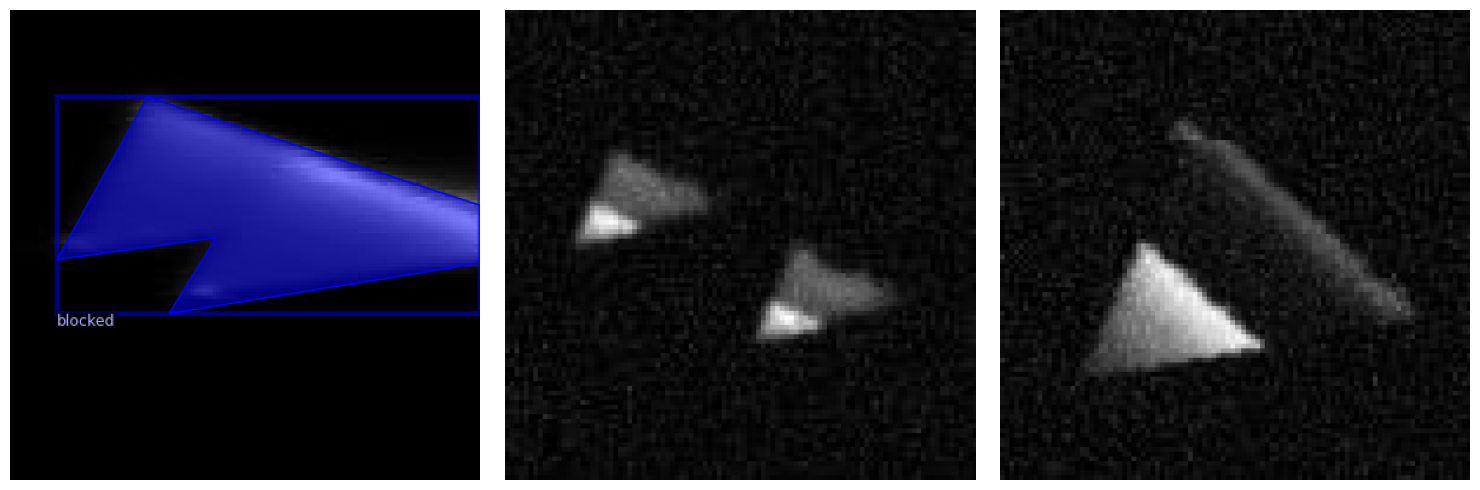

In [341]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_bias_triangle_dicts(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("csd_" + d).set(thing_classes=list(model_info['class_dict'].keys()))

csd_train_metadata = MetadataCatalog.get("csd_train")
csd_val_metadata = MetadataCatalog.get("csd_val")

# WHICH TO CHECK?
dataset_to_check = "train"

dataset_dir = MODEL_TRAIN_DATA_DIR if dataset_to_check == "train" else MODEL_VAL_DATA_DIR

dataset_dicts = get_bias_triangle_dicts(dataset_dir)

num_of_display_images = 3

num_cols = min(3, num_of_display_images)  # Maximum of 3 columns
num_rows = int(np.ceil(num_of_display_images / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, d in enumerate(random.sample(dataset_dicts, num_of_display_images)):
    print(d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_train_metadata, scale=3)
    out = visualizer.draw_dataset_dict(d)
    
    if num_rows > 1:
        ax = axs[i // num_cols, i % num_cols]
    else: 
        ax = axs[i % num_cols]
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.axis("off")

plt.tight_layout()
plt.show()



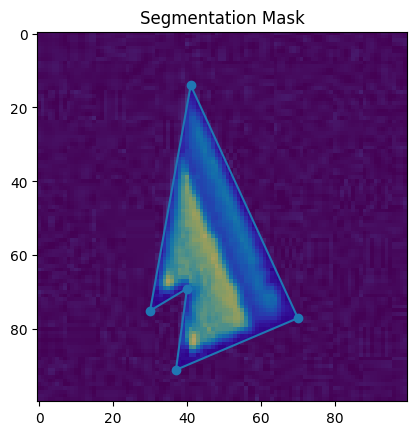

In [285]:
filename = "train_2_1_sim_blocked.jpg"
# filename = "train_1_blocked.jpg"
# filename = "train_3_unblocked.jpg"
json_file = os.path.join(MODEL_TRAIN_DATA_DIR, filename)
img = cv2.imread(json_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# xs = [64,24,51,39,156]
# ys=[38,124,116,140,110]
# xs = [21,1,99]
# ys = [3,60,46]
xs = [41,30,40,37,70]
ys = [14,75,69,91,77]
# xs = [38,13,48,34,119]
# ys = [19,74,64,91,72]
plt.imshow(img)
plt.fill(xs + [xs[0]], ys + [ys[0]], 'b-', alpha=0.3)  # Connect the last point to the first to close the polygon
plt.plot(xs + [xs[0]] ,ys + [ys[0]])
plt.scatter(xs,ys)
plt.title("Segmentation Mask")
plt.show()



### EXTRACT BASE LINE

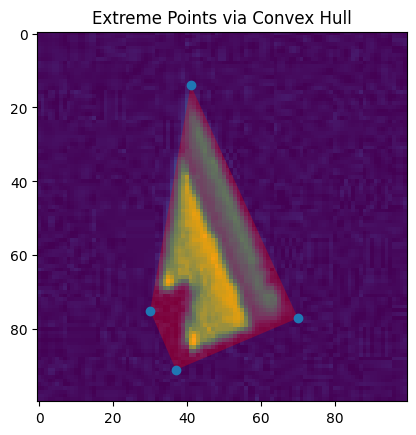

In [286]:
# Combine x and y coordinates into a list of tuples
points = list(zip(xs, ys))

import scipy

# Compute the convex hull of the points
hull = scipy.spatial.ConvexHull(points)

# Get the indices of the vertices forming the convex hull
hull_indices = hull.vertices

# Get the coordinates of the vertices forming the convex hull
convex_hull_points = [points[i] for i in hull_indices]
chull_points = np.array(convex_hull_points)

def dist(p1, p2):
    x1,y1 = p1
    x2,y2 = p2

    d = ((x2-x1)**2 + (y2-y1)**2)**0.5
    return d

def slope(p1, p2):
    x1,y1 = p1
    x2,y2 = p2

    m = (y2-y1)/(x2-x1)
    return m

xs, ys = chull_points[:,0],chull_points[:,1] 
points = list(zip(xs,ys))


corners_dict = {}
for i in range(len(points)+1):
    index1, index2 = i % len(points), (i+1) % len(points)
    p1, p2 = points[i % len(points)], points[(i+1) % len(points)]
    d = dist(p1,p2)
    m = slope(p1,p2)
    corners_dict[(index1,index2)] = {'dist': d, 'slope': m}

corners_dict_sorted = dict(sorted(corners_dict.items(), key=lambda item: item[1]['dist']))

min_dist = corners_dict_sorted[list(corners_dict_sorted.keys())[0]]['dist']
max_dist = corners_dict_sorted[list(corners_dict_sorted.keys())[-1]]['dist']
plt.imshow(img)
plt.fill(xs, ys, 'r-', alpha=0.3)  # Connect the last point to the first to close the polygon
plt.scatter(xs ,ys)
plt.title("Extreme Points via Convex Hull")
plt.show()

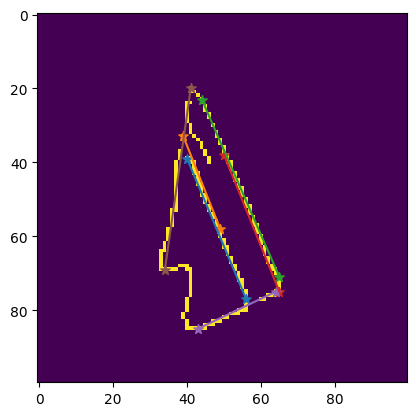

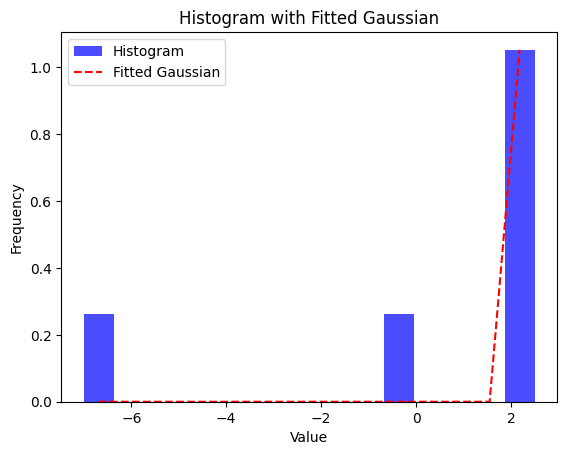

Fitted Mean: 2.4060698966036185
Fitted Standard Deviation: 0.1883428564195713
[((1, 2), {'dist': 69.35416353759881, 'slope': 2.1724137931034484, 'prob': 0.9812009722463514}), ((3, 0), {'dist': 17.46424919657298, 'slope': 2.2857142857142856, 'prob': 1.7269846050972704}), ((2, 3), {'dist': 35.84689665786984, 'slope': -0.42424242424242425, 'prob': 1.9447596176122825e-49}), ((0, 1), {'dist': 61.98386886924694, 'slope': -5.545454545454546, 'prob': 0.0})]
Key with the highest prob and highest dist: (1, 2)


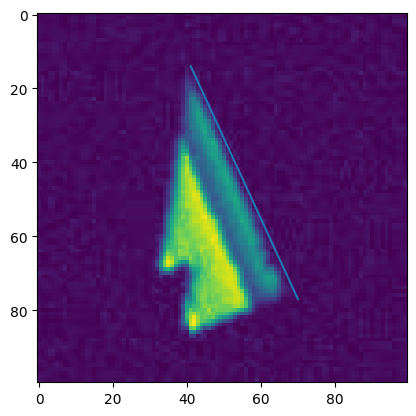

In [291]:
import scipy.optimize
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny


def create_polygon_mask(image_shape, polygon_points):
    # Create a blank mask image
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # Convert polygon points to numpy array format
    pts = np.array(polygon_points, np.int32)
    
    # Reshape points array into the required shape for fillPoly
    pts = pts.reshape((-1, 1, 2))
    
    # Draw filled polygon on the mask
    cv2.fillPoly(mask, [pts], 255)
    
    return mask

mask = create_polygon_mask(img.shape, chull_points)

edges = canny(img,sigma=2.1, mask=mask)

lines = probabilistic_hough_line(edges, line_length=int(np.average([min_dist, max_dist])/2))

slopes = []
for line in lines:
    p0, p1 = line
    if slope == 0 or (p1[0]-p0[0]) == 0 :
        continue
    slope = (p1[1]-p0[1])/(p1[0]-p0[0])

    slopes.append(slope)

    plt.scatter((p0[0], p1[0]), (p0[1], p1[1]), marker='*',s=50)
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

plt.imshow(edges)
plt.show()

# Sample data

# Create histogram
hist, bins = np.histogram(slopes, bins=15, density=True)

# Find bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Fit histogram data to a Gaussian distribution
(mu, sigma) = scipy.stats.norm.fit(img)

# Define Gaussian function
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Fit the Gaussian function to the histogram data
popt, _ = scipy.optimize.curve_fit(gaussian, bin_centers, hist, p0=[mu, sigma])

# Plot histogram
plt.hist(slopes, bins=15, density=True, alpha=0.7, color='blue', label='Histogram')

# Plot fitted Gaussian
plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label='Fitted Gaussian')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian')
plt.legend()
plt.show()

# Print mean and standard deviation of the fitted Gaussian
print("Fitted Mean:", popt[0])
print("Fitted Standard Deviation:", popt[1])

for indices, info in corners_dict_sorted.items():

    slope=info['slope']
    # Calculate the PDF of the fitted Gaussian at the given slope
    pdf_at_slope = scipy.stats.norm.pdf(slope, loc=popt[0], scale=popt[1])
    info['prob'] = pdf_at_slope
    # Print the probability

# Sort the dictionary based on 'prob' and then 'dist' keys in descending order
sorted_data = sorted(corners_dict_sorted.items(), key=lambda x: (np.abs(x[1]['prob'])**2 * x[1]['dist']), reverse=True)
print(sorted_data)
# Get the key with the highest prob and highest dist
key_with_highest_prob_and_dist = sorted_data[0][0]


# Print the key
print("Key with the highest prob and highest dist:", key_with_highest_prob_and_dist)

best_p1, best_p2 = chull_points[key_with_highest_prob_and_dist[0]], chull_points[key_with_highest_prob_and_dist[1]]
base_line = np.array([best_p1, best_p2])
plt.imshow(img)
plt.plot(base_line[:,0], base_line[:,1])
plt.show()


### GET DETUNING AXES

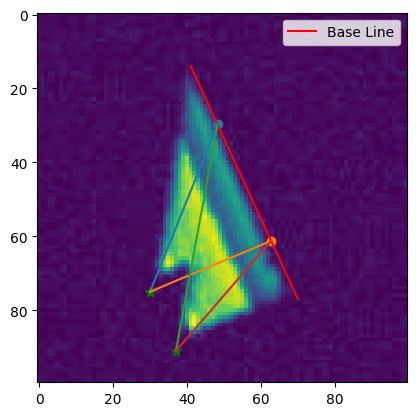

In [292]:
# Step 1, get points on the convex hull furthest from the baseline
possible_vertices = list(range(len(chull_points)))
#Note that you need to delete them in reverse order so that you don't throw off the subsequent indexes.

for i in sorted(key_with_highest_prob_and_dist,reverse=True):
    possible_vertices.pop(i)

def midpoint(point1, point2):
    return ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)

plt.imshow(img)
plt.plot(base_line[:,0], base_line[:,1],label='Base Line', c='r')
for i in possible_vertices:
    plt.scatter(chull_points[i,0], chull_points[i,1],marker='*', c='g',s=50)
M = midpoint(base_line[0], base_line[1])
M1 = midpoint(M, base_line[0])
M2 = midpoint(M, base_line[1])

plt.scatter(M1[0], M1[1])

for i in possible_vertices:
    plt.plot([chull_points[i][0]]+[M1[0]], [chull_points[i][1]]+[M1[1]])
    plt.plot([chull_points[i][0]]+[M2[0]], [chull_points[i][1]]+[M2[1]])
plt.scatter(M2[0], M2[1])
plt.legend(loc='best')



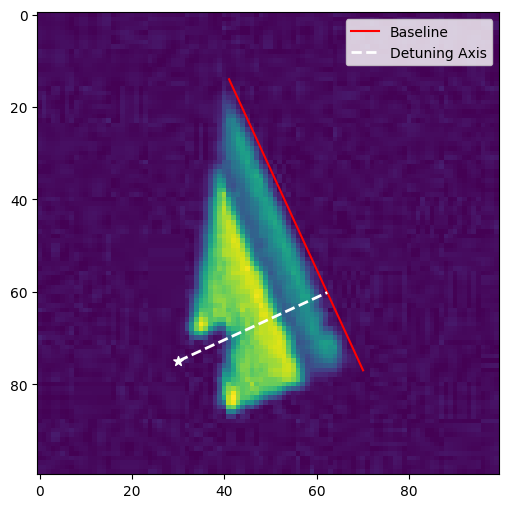

In [304]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_perpendicular_line(point1, point2, point):
    """Calculate the perpendicular line from a point to a line defined by two points."""
    # Calculate the slope of the original line
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0] + 1e-10)  # Avoid division by zero

    # Calculate the perpendicular slope
    slope_perpendicular = -1 / slope

    # Calculate the x-coordinate of the intersection point
    x_intersection = (point[1] - point1[1] + slope * point1[0] - slope_perpendicular * point[0]) / (slope - slope_perpendicular)

    # Calculate the y-coordinate of the intersection point
    y_intersection = slope * (x_intersection - point1[0]) + point1[1]

    return (x_intersection, y_intersection)

# Example points
point1 = base_line[0]
point2 = base_line[1]
point = chull_points[0]
intersection_point = calculate_perpendicular_line(point1, point2, point)
plt.figure(figsize=(8, 6))
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='red', label='Baseline')
plt.plot([point[0], intersection_point[0]], [point[1], intersection_point[1]], color='white', linestyle='--', linewidth=2, label='Detuning Axis')
plt.scatter(point[0], point[1], color='white',marker='*',s=50)


plt.imshow(img)
plt.legend(loc='best')
plt.show()
